---
title: "Path Integration using Coupled Bump Attractors"
date: 2024-05-25
author:
  - name: Arash Sal Moslehian
    id: asm
    email: arash.salmoslehian@epfl.ch
    affiliation: 
      - name: EPFL
        city: "Lausanne: "
        state: Vaud
  - name: Ludwig Tiston
    id: lt
    email: ludwig.tiston@epfl.ch
    affiliation: 
      - name: EPFL
        city: "Lausanne: "
        state: Vaud

abstract: > 
  Ants can return straight to their nest using an internal 'memory' of their location. This study will create a circuit to track ant movement with Poisson neurons and bump attractors, simulating and decoding their trajectory.
keywords:
  - Computational Neuroscience
  - Bump Attractor
jupyter: python3
format:
  gfm: default
  ieee-pdf: default 
  html:
    code-fold: true
execute:
  echo: false
---

In [72]:
#| output: false

# Imports

import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
# plt.rcParams['figure.dpi']=300
plt.rc('font', size=12)

In [73]:
#| output: false

# Function and Class definitions

def g(h, r0, alpha, beta):
    return r0 / (1 + np.exp(-2 * alpha * (h - beta)))

def raster_plot(spikes, time_points, dt, ax, **kwargs):
    event_series = spikes.astype(bool).tolist()
    event_series = [time_points[serie] for serie in event_series]
    ax.eventplot(event_series, **kwargs)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Neurons')

def generate_path(step_size, total_steps, max_angle=0.1):
    coords = [(0, 0)]   # Initial start location (x, y)
    headings = [0.002]         # Initial heading
    for i in range(total_steps - 1):
        headings.append(headings[i] + np.random.uniform(-1, 1) * np.pi * max_angle)
        x = coords[i][0] + step_size * np.cos(headings[-1])
        y = coords[i][1] + step_size * np.sin(headings[-1])
        coords.append((x, y))
        
    return np.asarray(coords), np.asarray(headings)


def compute_pop_vec(spikes, N, x_positions, dt, time_bin_window_size_ms = 10, complex_form = False):
    x_positions = np.exp(1j * x_positions) # n_neurons x 1
    # Create bins of time then count the spikes for each neuron in that bin.
    time_bin_window_size = int(time_bin_window_size_ms/dt) # timesteps
    # spikes: n_neurons x time_points
    n_bins = int(np.floor(spikes.shape[1] / time_bin_window_size))
    population_vector = np.zeros(n_bins, dtype=complex) # n_bins x 1
    time_binned_spikes = np.zeros((N, n_bins)) # n_neurons x n_bins
    
    # Calculate the population vector over time (in time bins). The population vector is just the
    # mean of neurons' preferred direction weighted by their number of spikes in that time bin.
    for idx, bin_start in enumerate(range(0, spikes.shape[1], time_bin_window_size)): 
        time_binned_spikes[:,idx] = np.mean(spikes[:, bin_start:bin_start+time_bin_window_size], axis=1)
        if np.sum(time_binned_spikes[:,idx]) > 0:
            population_vector[idx] = np.dot(time_binned_spikes[:,idx], x_positions) / (np.sum(time_binned_spikes[:,idx]))
        else:
            population_vector[idx] = np.nan

    if complex_form:
        return population_vector
    else:
        population_vector = np.angle(population_vector)
        # Convert from -pi to pi to 0 to 2pi
        population_vector = np.mod(population_vector, 2*np.pi)
        return population_vector

def compute_plot_pop_vec(spikes, N, x_positions, dt, ax, time_bin_window_size_ms = 10,  is_polar=False, **kwargs):
    population_vector = compute_pop_vec(spikes, N, x_positions, dt, time_bin_window_size_ms=time_bin_window_size_ms)

    plot_pop_vec(population_vector, dt, ax, time_bin_window_size_ms=time_bin_window_size_ms, is_polar=is_polar, **kwargs) 
    
    return population_vector

def plot_pop_vec(population_vector, dt, ax, time_bin_window_size_ms = 10,  is_polar=False, **kwargs):
    if is_polar:
        ax.plot(population_vector, range(len(population_vector)), **kwargs)
        ax.set_rmax(len(population_vector))
        ax.yaxis.set_label_coords(-0.1, 0.5)  # Move ylabel to the left
    else:
        ax.plot(population_vector, **kwargs)
        ax.set_ylim(0, 2*np.pi)

    ax.set_xlabel('Time point (dt = {}, bin size (ms) = {})'.format(dt, time_bin_window_size_ms))
    ax.set_ylabel('Direction (radians)')

def dummy_plot(ax = None):
    if ax is not None:
        ax.axis('off')
    else:
        fig, ax = plt.subplots()
        ax.axis('off')
        plt.show()

def single_plot_handler(fig, axes):
    dummy_plot(axes[0])
    dummy_plot(axes[2])
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.8))

class NeuronPopultion():
    def __init__(self, N, J, x_range, time_points, I0, R, tau, dt, omega, alpha, beta, r0, h_initial = None):
        self.N = N
        self.J = J
        self.x_positions = np.linspace(x_range[0], x_range[1], N)

        if h_initial is None:
            self.h_initial = np.random.uniform(0, 1, N)
        else:
            self.h_initial = h_initial
            
        self.time_points = time_points
        self.I_input = np.zeros((N, len(time_points)))
        self.h_values = np.zeros((N, len(time_points)))
        self.h_values[:, 0] = self.h_initial
        self.spikes = np.zeros((N, len(time_points)), dtype=float)
        self.I0 = I0
        self.R = R
        self.tau = tau
        self.dt = dt
        self.omega = omega
        self.alpha = alpha
        self.beta = beta
        self.r0 = r0

    def sim_timestep(self, I_input, t, dt):
        self.I_input[:, t] = I_input
        h_prev = self.h_values[:, t - 1]
        dh_dt = (-h_prev + self.R * self.I_input[:, t]) / self.tau
        self.h_values[:, t] = h_prev + dt * dh_dt
        r = g(self.h_values[:, t], self.r0, self.alpha, self.beta)
        spike_probs = r * dt
        self.spikes[:, t] = (np.random.random(self.N) < spike_probs).astype(float) / dt

    def compute_pop_vec(self, time_bin_window_size_ms = 10, complex_form = False):
        return compute_pop_vec(self.spikes, self.N, self.x_positions, self.dt, time_bin_window_size_ms=time_bin_window_size_ms, complex_form=complex_form)

    def compute_plot_pop_vec(self, ax, time_bin_window_size_ms = 10, is_polar=False, **kwargs):
        return compute_plot_pop_vec(self.spikes, self.N, self.x_positions, self.dt, ax, time_bin_window_size_ms = time_bin_window_size_ms, is_polar=is_polar,  **kwargs)

    def mean_spike_plot(self, ax):
        mean_spikes = np.mean(self.spikes, axis=0) / self.dt
        mean_spikes = np.mean(mean_spikes.reshape(-1, 10), axis=1)
        time_points_ms = np.arange(0, T, 1)
        ax.plot(time_points_ms, mean_spikes)
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Firing Rate (spikes/ms)')

    def mean_spike_time_plot(self, ax):
        ax.plot(np.mean(self.spikes, axis=1))
        ax.set_xlabel('Neuron')
        ax.set_ylabel('Mean Spikes')

**Ex.0.1**: We can see in @fig-ex0-1 a) As $\beta$ increases (keeping $\alpha = 2$ constant), the function is shifted to the right and as it decreases the function moves to the left.  In @fig-ex0-1 b) As $\alpha$ increases (keeping $\beta = 0.5$ constant), the transition gets steeper and as it decreases, the transition gets less steep. 

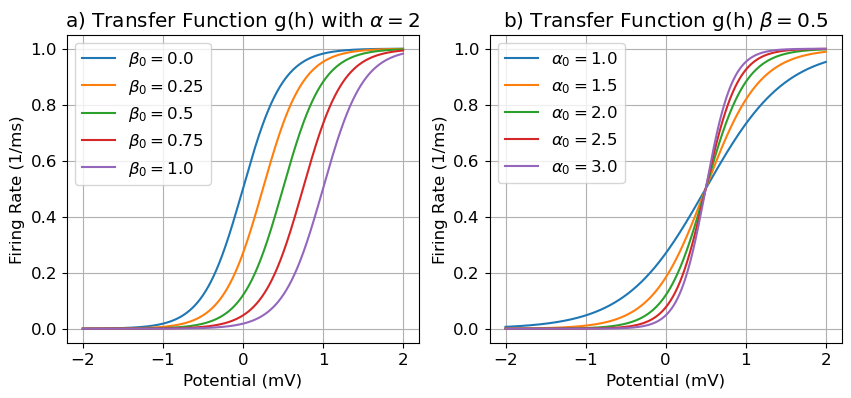

In [106]:
#| label: fig-ex0-1
#| fig-cap: "The transfer function $g$ as a funciton of the potential $h$. a) Changing $\\beta$ while keeping $\\alpha$ constant. b) Changing $\\alpha$ while keeping $\\beta$ constant."

h_range = np.linspace(-2, 2, 1000)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for beta in np.linspace(0, 1, 5):
    axs[0].plot(h_range, g(h_range, r0=1, alpha=2, beta=beta), label="$\\beta_0 = {}$".format(beta))
    axs[0].set_title('a) Transfer Function g(h) with $\\alpha = 2$')
    axs[0].set_xlabel('Potential (mV)')
    axs[0].set_ylabel('Firing Rate (1/ms)')
    axs[0].legend()
    axs[0].grid(True)

for alpha in np.linspace(1, 3, 5):
    axs[1].plot(h_range, g(h_range, r0=1, alpha=alpha, beta=0.5), label="$\\alpha_0 = {}$".format(alpha))
    axs[1].set_title('b) Transfer Function g(h) $\\beta = 0.5$')
    axs[1].set_xlabel('Potential (mV)')
    axs[1].set_ylabel('Firing Rate (1/ms)')
    axs[1].legend()
    axs[1].grid(True)

plt.show()

**Ex.0.2**: @fig-ex0-2 a) compares the mean number of spikes per ms across the $N$ neurons to the theoretical instantaneous rate. We can see that the simulated firing rate is slightly delayed compared to the theoretical rate and has more fluctuations. As we increase the number of neurons to $N = 1000$ in @fig-ex0-2 b) we can see the simulated firing rate is smoother and closer to the instantaneous rate. The fluctuations arise from the limited amount of neurons, as they increase the better approximate this mean-field limit. The delay stems from the timeconstant/scale which the instantaneous rate does not consider.

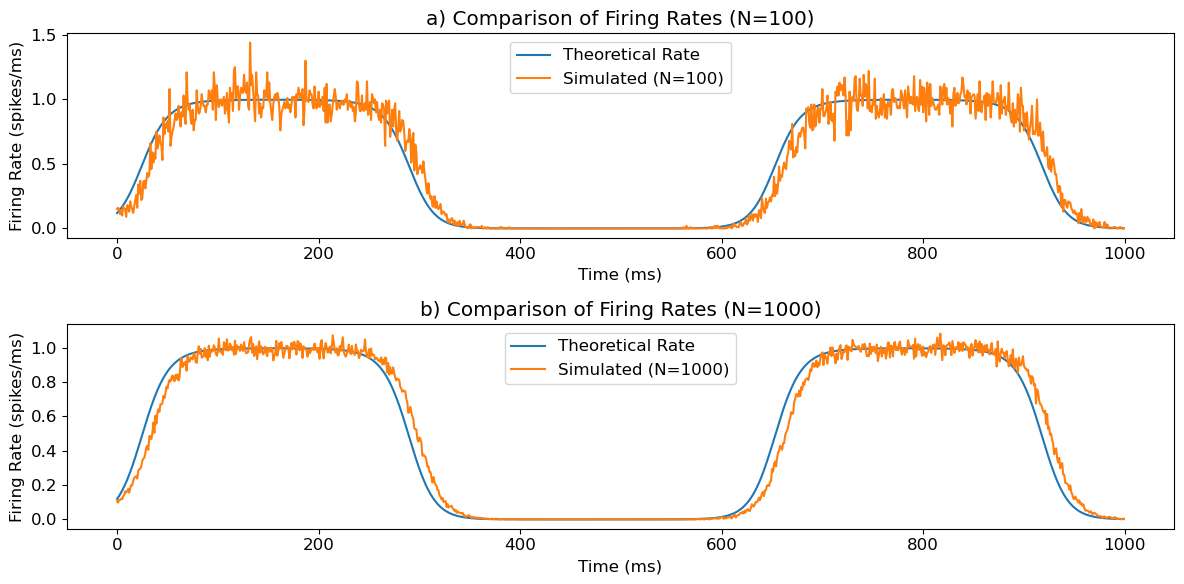

In [101]:
#| label: fig-ex0-2
#| fig-cap: "Comparinson of simulated firing rate and the theoretical rate. a) With $N = 100$ neurons b) With $N = 1000$ neurons."

def exercise0():
    N = 100
    T = 1000
    I0 = 2
    R = 1
    tau = 10
    dt = 0.1
    omega = 0.01
    alpha = 2
    beta = 0.5
    r0 = 1

    initial_h = np.zeros(N)
    time_points = np.arange(0, T, dt)
    I_input = np.array([I0 * np.sin(omega * time_points)] * N)

    def simulate_neurons(h_initial, I_input, T):
        num_neurons = len(h_initial)
        num_steps = int(T / dt)
        h_values = np.zeros((num_neurons, num_steps))
        spikes = np.zeros((num_neurons, num_steps), dtype=bool)

        h_values[:, 0] = h_initial

        for t in range(1, num_steps):
            h_prev = h_values[:, t - 1]
            I = R * I_input[:, t]
            dh_dt = (-h_prev + I) / tau
            h_values[:, t] = h_prev + dt * dh_dt
            r = g(h_values[:, t], r0, alpha, beta)
            spike_probs = r * dt
            spikes[:, t] = np.random.random(num_neurons) < spike_probs

        return h_values, spikes

    h_values_100, spikes_100 = simulate_neurons(initial_h, I_input, T)
    mean_spikes_100 = np.mean(spikes_100, axis=0) / dt
    mean_spikes_100 = np.mean(mean_spikes_100.reshape(-1, 10), axis=1)

    time_points_ms = np.arange(0, T, 1)
    theoretical_rate = g(R* I0 * np.sin(omega * time_points_ms), r0, alpha, beta)

    N = 1000
    initial_h = np.zeros(N)
    I_input = np.array([R*I0 * np.sin(omega * time_points)] * N)
    h_values_1000, spikes_1000 = simulate_neurons(initial_h, I_input, T)
    mean_spikes_1000 = np.mean(spikes_1000, axis=0)/dt
    mean_spikes_1000 = np.mean(mean_spikes_1000.reshape(-1, 10), axis=1)

    fig, axs = plt.subplots(2, 1, figsize=(12, 6))
    axs[0].plot(time_points_ms, theoretical_rate, label='Theoretical Rate')
    axs[0].plot(time_points_ms, mean_spikes_100, label='Simulated (N=100)')
    axs[0].set_xlabel('Time (ms)')
    axs[0].set_ylabel('Firing Rate (spikes/ms)')
    axs[0].set_title('a) Comparison of Firing Rates (N=100)')
    axs[0].legend()

    axs[1].plot(time_points_ms, theoretical_rate, label='Theoretical Rate')
    axs[1].plot(time_points_ms, mean_spikes_1000, label='Simulated (N=1000)')
    axs[1].set_xlabel('Time (ms)')
    axs[1].set_ylabel('Firing Rate (spikes/ms)')
    axs[1].set_title('b) Comparison of Firing Rates (N=1000)')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

exercise0()

**Ex.1.1**: In @fig-ex1-1 a) shows the raster plot of the recurrent network with no external input. The initial conditions are sampled from $h_i(0) ~ Uniform (0, 1)$ mV. @fig-ex1-1 b) shows the mean firing rate of all the neurons for different values of $J$. For $J > 4.7$ we can consistently get a bump.  


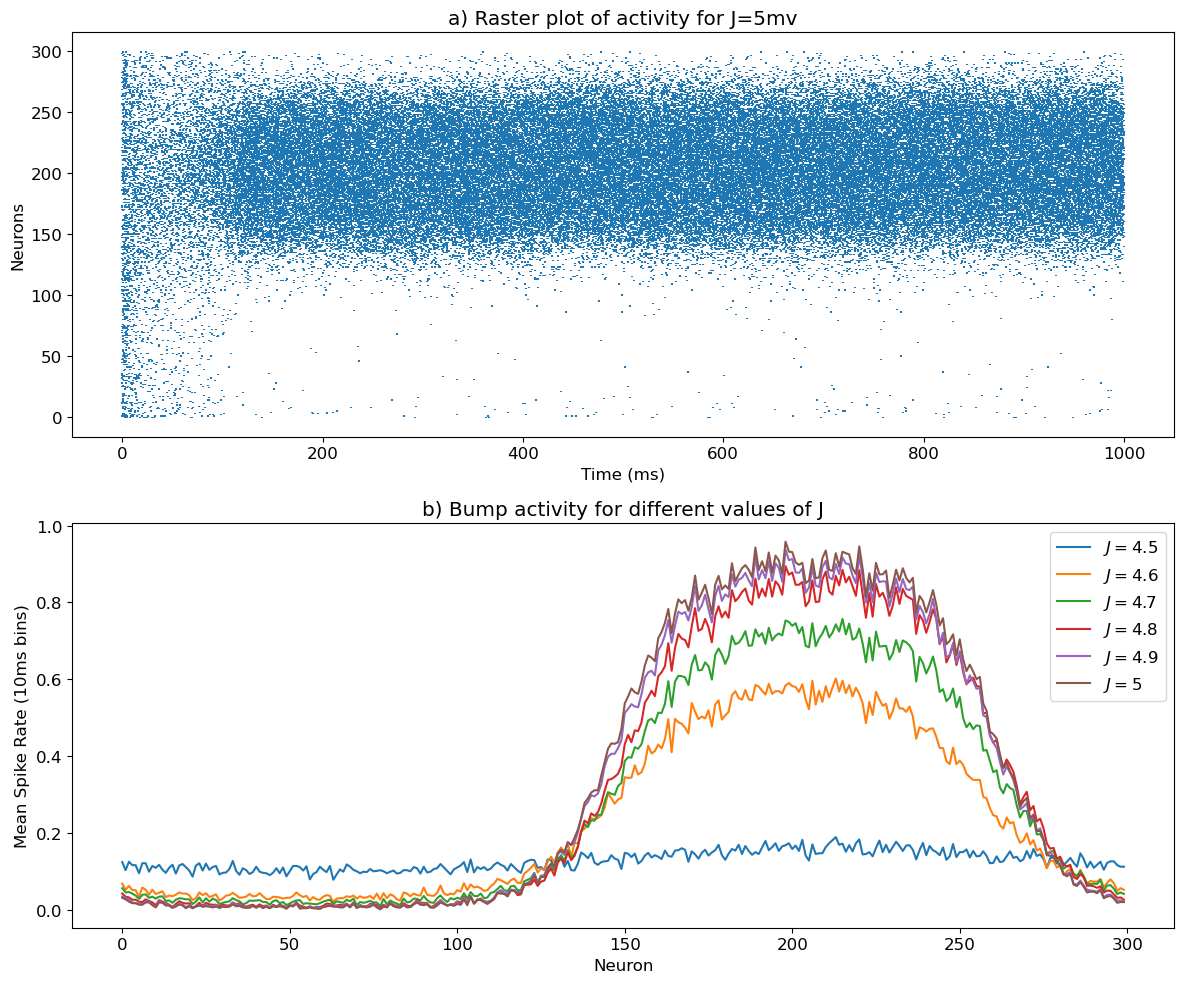

In [93]:
#| label: fig-ex1-1
#| fig-subcap: 
#|   - "Raster plot of the recurrent network."
#|   - "Mean firing rate of all neurons fir different values of $J$"
#| layout-nrow: 2

def exercise1_1(J, raster_ax = None, mean_ax = None):
    N = 300
    T = 1000
    J = J
    I0 = 2
    R = 1
    tau = 10
    dt = 0.1
    omega = 0.01
    alpha = 2
    beta = 0.5
    r0 = 1
    np.random.seed(42)
    x_positions = np.linspace(0, 2*np.pi, N)
    initial_h = np.random.uniform(0, 1, N)
    time_points = np.arange(0, T, dt)
    I_input = np.zeros((N, len(time_points)))

    def simulate_neurons(h_initial, I_input, T):
        num_neurons = len(h_initial)
        num_steps = int(T / dt)
        h_values = np.zeros((num_neurons, num_steps))
        spikes = np.zeros((num_neurons, num_steps), dtype=float)
        h_values[:, 0] = h_initial

        for t in range(1, num_steps):
            m_cos = np.sum(np.cos(x_positions) * spikes[:, t-1])/N
            m_sin = np.sum(np.sin(x_positions) * spikes[:, t-1])/N
            I_input[:, t] = J * (np.cos(x_positions) * m_cos + np.sin(x_positions) * m_sin) 

            h_prev = h_values[:, t - 1]
            I = R * I_input[:, t]
            dh_dt = (-h_prev + I) / tau
            h_values[:, t] = h_prev + dt * dh_dt
            r = g(h_values[:, t], r0, alpha, beta)
            spike_probs = r * dt
            spikes[:, t] = (np.random.random(num_neurons) < spike_probs).astype(float)/dt

        return h_values, spikes

    h_values, spikes = simulate_neurons(initial_h, I_input, T)

    if raster_ax is not None:
        raster_plot(spikes, time_points, dt, raster_ax)

    if mean_ax is not None:
        mean_ax.plot(np.mean(spikes, axis=1), label="$J = {}$".format(J))





fig, axs = plt.subplots(2, 1, figsize=(12, 10))

exercise1_1(5, raster_ax=axs[0])
axs[0].set_title("a) Raster plot of activity for J=5mv")

axs[1].set_xlabel('Neuron')
axs[1].set_ylabel('Mean Spike Rate (10ms bins)')
axs[1].set_title("b) Bump activity for different values of J")


for J in [4.5, 4.6, 4.7, 4.8, 4.9, 5]:
    exercise1_1(J, mean_ax=axs[1])

axs[1].legend()
plt.tight_layout()
plt.show()


**Ex.1.2**: @fig-ex1-2 shows the location of $\theta_{bump}$ for different values of $dt$. As we increase the time scale we see the bump drift and move around a bit.

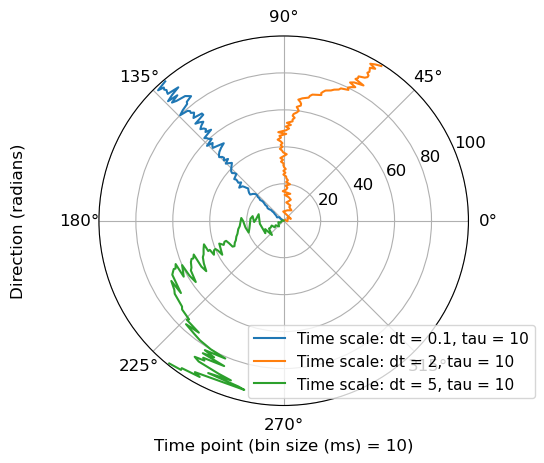

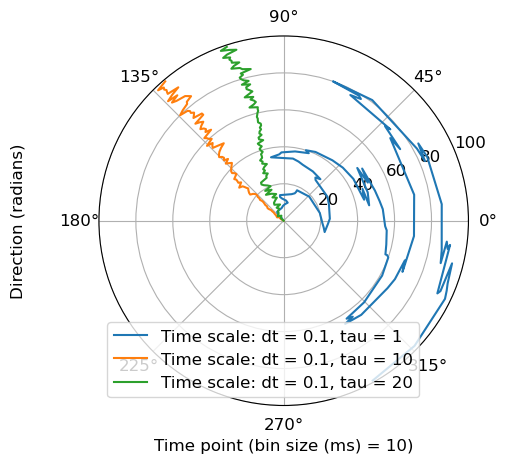

In [126]:
#| label: fig-ex1-2
#| fig-cap: "Location of $\\theta_{bump}$ over time for different time scale."
#| fig-subcap: 
#|   - "Bump location for different values of $dt$ "
#|   - "Bump location for different values of $\\tau$"
#| layout-ncol: 2

def exercise1_2(ax, dt = 0.1, tau = 10):
    N = 300
    T = 1000
    J = 5
    I0 = 2
    R = 1
    dt = dt
    omega = 0.01
    alpha = 2
    beta = 0.5
    r0 = 1
    np.random.seed(40)
    x_positions = np.linspace(0, 2*np.pi, N)
    initial_h = np.random.uniform(0, 1, N)
    time_points = np.arange(0, T, dt)
    I_input = np.zeros((N, len(time_points)))

    def simulate_neurons(h_initial, I_input, T):
        num_neurons = len(h_initial)
        num_steps = int(T / dt)
        h_values = np.zeros((num_neurons, num_steps))
        spikes = np.zeros((num_neurons, num_steps), dtype=float)
        h_values[:, 0] = h_initial

        for t in range(1, num_steps):
            m_cos = np.sum(np.cos(x_positions) * spikes[:, t-1])/N
            m_sin = np.sum(np.sin(x_positions) * spikes[:, t-1])/N
            I_input[:, t] = J * (np.cos(x_positions) * m_cos + np.sin(x_positions) * m_sin) 

            h_prev = h_values[:, t - 1]
            I = R * I_input[:, t]
            dh_dt = (-h_prev + I) / tau
            h_values[:, t] = h_prev + dt * dh_dt
            r = g(h_values[:, t], r0, alpha, beta)
            spike_probs = r * dt
            spikes[:, t] = (np.random.random(num_neurons) < spike_probs).astype(float)/dt

        return h_values, spikes


    h_values, spikes = simulate_neurons(initial_h, I_input, T)
    time_bin_window_size_ms = 10
    population_vector = compute_pop_vec(spikes, N, x_positions, dt, time_bin_window_size_ms=time_bin_window_size_ms)
    
    ax.plot(population_vector, range(len(population_vector)), label='Time scale: dt = {}, tau = {}'.format(dt, tau))
    ax.set_rmax(len(population_vector))
    ax.set_xlabel('Time point (bin size (ms) = {})'.format(time_bin_window_size_ms))
    ax.set_ylabel('Direction (radians)')
    ax.yaxis.set_label_coords(-0.2, 0.5)  # Move ylabel to the left
    

fig, axs = plt.subplots(1, 1, subplot_kw={'projection': 'polar'})
for dt in [0.1, 2, 5]:
    exercise1_2(axs, dt=dt)
plt.legend(loc="lower right", fontsize=11, bbox_to_anchor=(1.2, 0))
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 1, subplot_kw={'projection': 'polar'})
for tau in [1, 10, 20]:
    exercise1_2(axs, tau=tau)
plt.legend()
plt.tight_layout()
plt.show()


**Ex.1.3**: The drift in the location of the bump is primarily caused by the discrete nature and finite size of the network. Increasing $N$ can provide a more continues approximation of the underlying dynamics and reduce the drift. Smaller $dt$ makes the integration more accurate and causes the network to drift less. A smaller timeconstant $\tau$ amplifies these discrete fluctuations further. As seen in @fig-ex1-2 larger time scales cause more drift.


**Ex.1.4**: @fig-ex1-4 shows the result of stimulating the network using the gaussian inputs. These input create transient increase in the firing rate of neurons that are around the centers of the inputs. We see increased activity around the mean of the inputs during the time that they are on. The recurrent connections will help sustain the bump of activity for some time even after the external input is removed. The cosine connectivity profile means that neurons that are spatially close are more strongly connected. Therefore, an increase in activity at the center of the input will spread to neighboring neurons due to the recurrent connections.

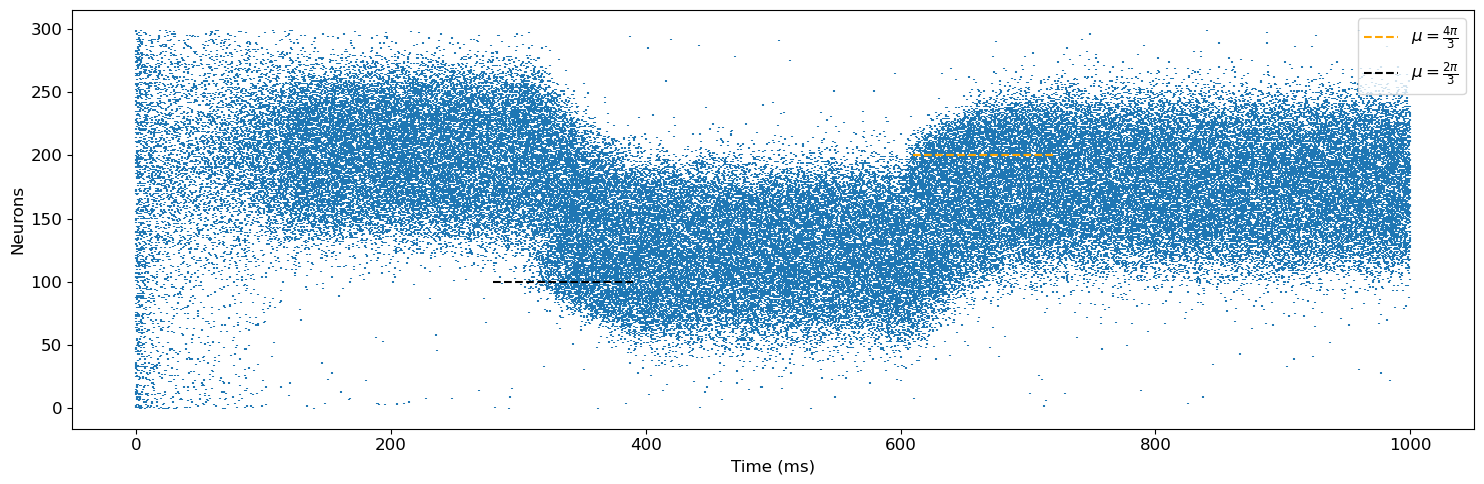

In [95]:
#| label: fig-ex1-4
#| fig-cap: "Raster plot of the spikes with external input. The dashed lines outline the mean of the input gaussian."

def exercise1_4():
    N = 300
    T = 1000
    J = 5
    I0 = 2
    R = 1
    tau = 10
    dt = 0.1
    omega = 0.01
    alpha = 2
    beta = 0.5
    r0 = 1
    np.random.seed(42)

    x_positions = np.linspace(0, 2*np.pi, N)
    initial_h = np.random.uniform(0, 1, N)
    time_points = np.arange(0, T, dt)
    I_input = np.zeros((N, len(time_points)))

    # Create the rquired external input based on the specification.
    I_ext = np.zeros((N, len(time_points)))
    I_ext_sigma = np.pi/8
    I_ext_mu = np.pi/3

    def I_ext_gaussian(x, k):
        return 1/(np.sqrt(2*np.pi)*I_ext_sigma) * np.exp(-(x - k*I_ext_mu)**2/(2*I_ext_sigma**2))
    
    I_ext[:, int(300/dt):int(400/dt)] = np.tile(I_ext_gaussian(x_positions, 2).reshape(N, 1), int(400/dt)-int(300/dt))
    I_ext[:, int(600/dt):int(700/dt)] = np.tile(I_ext_gaussian(x_positions, 4).reshape(N, 1), int(700/dt)-int(600/dt))


    def simulate_neurons(h_initial, I_input, T):
        num_neurons = len(h_initial)
        num_steps = int(T / dt)
        h_values = np.zeros((num_neurons, num_steps))
        spikes = np.zeros((num_neurons, num_steps), dtype=float)
        h_values[:, 0] = h_initial

        for t in range(1, num_steps):
            m_cos = np.sum(np.cos(x_positions) * spikes[:, t-1])/N
            m_sin = np.sum(np.sin(x_positions) * spikes[:, t-1])/N
            I_input[:, t] = J * (np.cos(x_positions) * m_cos + np.sin(x_positions) * m_sin) + I_ext[:, t]

            h_prev = h_values[:, t - 1]
            I = R * I_input[:, t]
            dh_dt = (-h_prev + I) / tau
            h_values[:, t] = h_prev + dt * dh_dt
            r = g(h_values[:, t], r0, alpha, beta)
            spike_probs = r * dt
            spikes[:, t] = (np.random.random(num_neurons) < spike_probs).astype(float)/dt

        return h_values, spikes


    h_values, spikes = simulate_neurons(initial_h, I_input, T)
    time_bin_window_size_ms = 10
    population_vector = compute_pop_vec(spikes, N, x_positions, dt, time_bin_window_size_ms=time_bin_window_size_ms)

    fig, axs = plt.subplots(1, 1, figsize=(15, 5))
    raster_plot(spikes, time_points, dt, axs)
    axs.axhline(y=np.where(x_positions >= 4*I_ext_mu)[0][0], xmin=0.6, xmax=0.7, color='orange', linestyle='--', label=r'$\mu = \frac{4 \pi}{3}$')
    axs.axhline(y=np.where(x_positions >= 2*I_ext_mu)[0][0], xmin=0.3, xmax=0.4, color='black', linestyle='--', label=r'$\mu = \frac{2 \pi}{3}$')

    plt.legend()
    plt.tight_layout()
    plt.show()

exercise1_4()

**Ex.1.5**: In @fig-ex1-5 we see that when a small angle bias is added to the connectivity profile, the bumps position shifts/rotates over time. As $\phi$ increases, the frequency of rotation increased. This is as expected, as the neurons are now stimulated at all times as if there was a bump slightly shifted from it, so it tried to "chase the shadow" in each timestep.

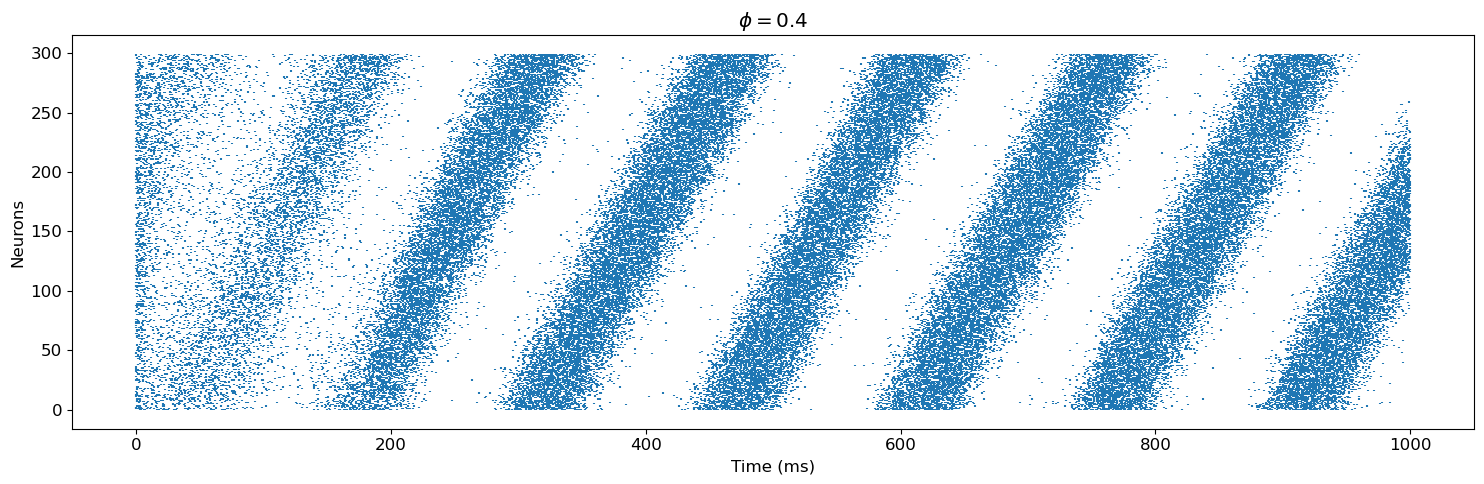

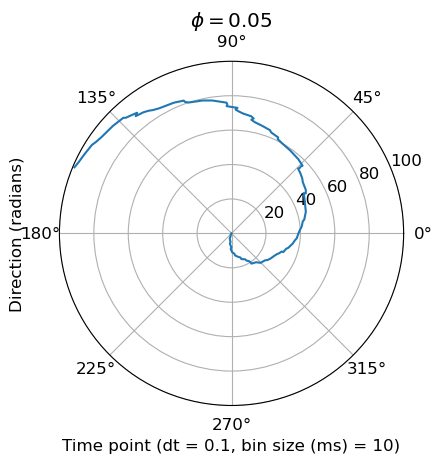

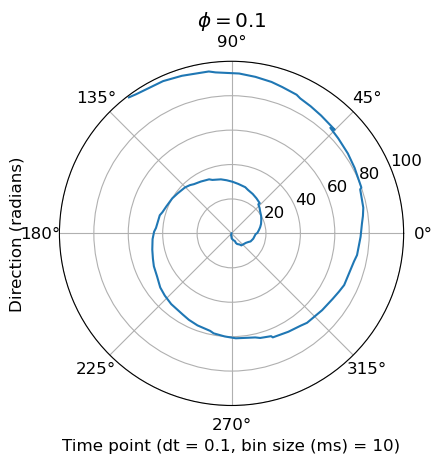

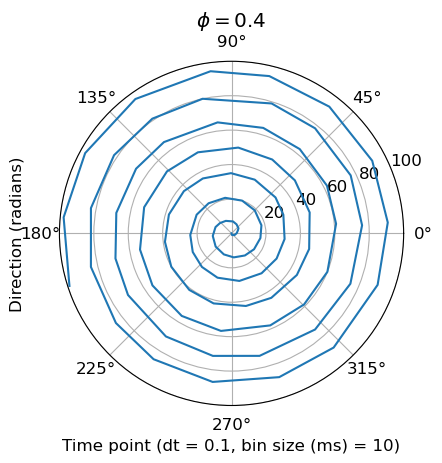

In [96]:
#| label: fig-ex1-5
#| fig-cap: "Raster plot of the spikes with a biased angle $\\phi$ in connectivity profile."
#| fig-subcap: 
#|   - "Raster plot of the firing acitvity for $\\phi = 0.4$."
#|   - "$\\theta_{bump}$ for $\\phi = 0.05$."
#|   - "$\\theta_{bump}$ for $\\phi = 0.1$."
#|   - "$\\theta_{bump}$ for $\\phi = 0.4$."
#| layout: [[1], [1, 1, 1]]

def exercise1_5(phi, pop_vec_axs = None, plot_raster = False):
    N = 300
    T = 1000
    J = 5
    I0 = 2
    R = 1
    tau = 10
    dt = 0.1
    omega = 0.01
    alpha = 2
    beta = 0.5
    r0 = 1
    np.random.seed(42)

    x_positions = np.linspace(0, 2*np.pi, N)
    initial_h = np.random.uniform(0, 1, N)
    time_points = np.arange(0, T, dt)
    I_input = np.zeros((N, len(time_points)))

    def simulate_neurons(h_initial, I_input, T):
        num_neurons = len(h_initial)
        num_steps = int(T / dt)
        h_values = np.zeros((num_neurons, num_steps))
        spikes = np.zeros((num_neurons, num_steps), dtype=float)
        h_values[:, 0] = h_initial

        for t in range(1, num_steps):
            m_cos = np.sum(np.cos(x_positions) * spikes[:, t-1])/N
            m_sin = np.sum(np.sin(x_positions) * spikes[:, t-1])/N
            I_input[:, t] = J * (np.cos(x_positions-phi) * m_cos + np.sin(x_positions-phi) * m_sin) 

            h_prev = h_values[:, t - 1]
            I = R * I_input[:, t]
            dh_dt = (-h_prev + I) / tau
            h_values[:, t] = h_prev + dt * dh_dt
            r = g(h_values[:, t], r0, alpha, beta)
            spike_probs = r * dt
            spikes[:, t] = (np.random.random(num_neurons) < spike_probs).astype(float)/dt

        return h_values, spikes


    h_values, spikes = simulate_neurons(initial_h, I_input, T)

    time_bin_window_size_ms = 10
    population_vector = compute_pop_vec(spikes, N, x_positions, dt, time_bin_window_size_ms=time_bin_window_size_ms)

    if plot_raster:
        fig, axs = plt.subplots(1, 1, figsize=(15, 5))
        raster_plot(spikes, time_points, dt, axs)
        axs.set_title(r'$\phi = 0.4$')
    else:
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        ax.plot(population_vector, range(len(population_vector)))
        ax.set_title('$\\phi = {}$'.format(phi))
        ax.set_xlabel('Time point (dt = {}, bin size (ms) = {})'.format(dt, time_bin_window_size_ms))
        ax.set_rmax(len(population_vector))
        ax.set_ylabel('Direction (radians)')
        ax.yaxis.set_label_coords(-0.1, 0.5)  # Move ylabel to the left



exercise1_5(0.4, plot_raster = True)
plt.tight_layout()
plt.show()

for i in [0.05, 0.1, 0.4]:
    exercise1_5(i)
    plt.tight_layout()
    plt.show()


**Ex.1.6**: @fig-ex1-6 shows the raster plot for bump attractor model using the gaussian tuning curve for $N = 100$ neurons and $T = 300$ ms as the simulation is computationally intensive. We also added a small $\phi = 0.2$ like the previous case to easier see the behaviour of the bump near the edges. From the lectures we know we want a connectivity profile that is like a "mexican hat". That is exitation close, inhibiton further away, and close to no interaction even further. The values $J_0=-2, J_1=4.5, \sigma=1$ fit this description and does generate a stable bump. The periodic nature of the ring model eliminates any boundary effect. For the line model, the two ends of the simulation space are not connected as in the the ring model. This has the effect that the bump gets stuck as the edge, instead of wrapping around.The bump cannot move further to the edge as there aren't enough neurons to stimulate it in that direction. We can see that with a small $\phi$ the bump is stuck at the edge and does not wrap around like in @fig-ex1-5.

  0%|                                                                                                                        | 0/4999 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:53<00:00, 92.73it/s]


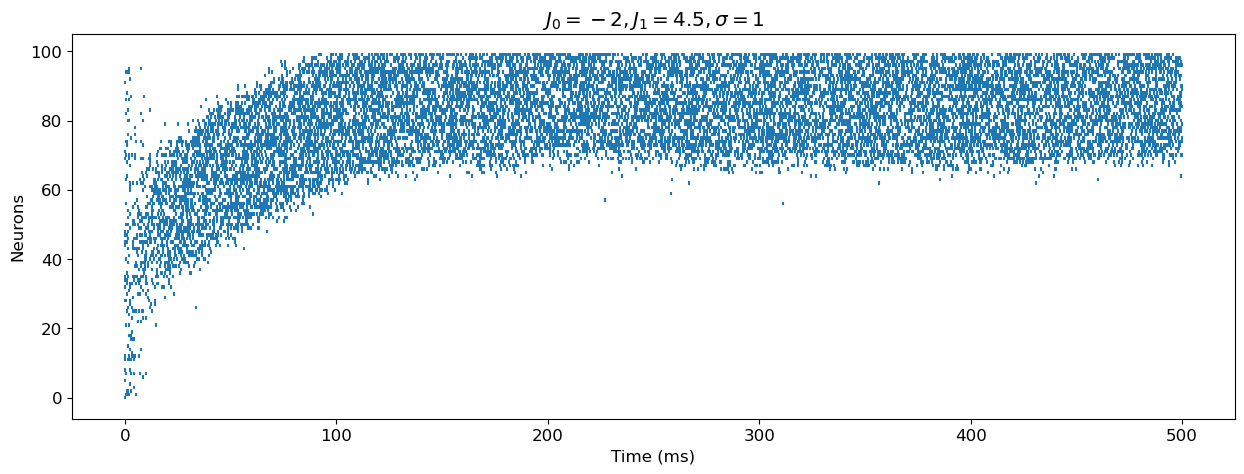

In [97]:
#| label: fig-ex1-6
#| fig-cap: "Bump attractor model using gaussian tuning curve."

def exercise1_6(J0, J1, sigma, plot_pop_vec = False):
    N = 100
    T = 500
    I0 = 2
    J = 5
    phi = 0.2
    R = 1
    tau = 10
    dt = 0.1
    omega = 0.01
    alpha = 2
    beta = 0.5
    r0 = 1
    np.random.seed(42)

    x_positions = np.linspace(0, 2*np.pi, N)
    initial_h = np.random.uniform(0, 1, N)
    time_points = np.arange(0, T, dt)
    I_input = np.zeros((N, len(time_points)))

    def w(xi, xj, J0, J1, sigma):
        return J0 + J1*np.exp(-(xi-phi - xj)**2/(2*sigma**2))

    def simulate_neurons(h_initial, I_input, T):
        num_neurons = len(h_initial)
        num_steps = int(T / dt)
        h_values = np.zeros((num_neurons, num_steps))
        spikes = np.zeros((num_neurons, num_steps), dtype=float)
        h_values[:, 0] = h_initial

        for t in tqdm(range(1, num_steps)):
            
            for i in range(N):
                accum = 0
                for j in range(N):
                    accum = accum + w(x_positions[i], x_positions[j], J0, J1, sigma) * spikes[j, t-1]
                I_input[i, t] = J/N * accum

            h_prev = h_values[:, t - 1]
            I = R * I_input[:, t]
            dh_dt = (-h_prev + I) / tau
            h_values[:, t] = h_prev + dt * dh_dt
            r = g(h_values[:, t], r0, alpha, beta)
            spike_probs = r * dt
            spikes[:, t] = (np.random.random(num_neurons) < spike_probs).astype(float)/dt

        return h_values, spikes


    h_values, spikes = simulate_neurons(initial_h, I_input, T)
    time_bin_window_size_ms = 10
    population_vector = compute_pop_vec(spikes, N, x_positions, dt, time_bin_window_size_ms=time_bin_window_size_ms)

    fig, axs = plt.subplots(1, 1, figsize=(15, 5))
    raster_plot(spikes, time_points, dt, axs)
    axs.set_title('$J_0 = {}, J_1 = {}, \\sigma = {}$'.format(J0, J1, sigma))
    plt.show()

    if plot_pop_vec:
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        ax.plot(population_vector, range(len(population_vector)))
        ax.set_title('$J_0 = {}, J_1 = {}, \\sigma = {}$'.format(J0, J1, sigma))
        ax.set_xlabel('Time point (dt = {}, bin size (ms) = {})'.format(dt, time_bin_window_size_ms))
        ax.set_rmax(len(population_vector))
        ax.set_ylabel('Direction (radians)')
        plt.show()

exercise1_6(J0=-2, J1=4.5, sigma=1)

**Ex.2.1**: Equation @eq-ex2_1 shows the equation of the full input received for each neuron in both populations.  The push-pull system is formed as the result of two opposing "forces" in balance, acting on each population/bump. The phase shift $\theta$ is pushing it in one direction, but the stimulation from the other neuron population is pulling it in the other direction (through the weights $w_{R \rightarrow L}$ and $w_{L \rightarrow R}$). 

 When one population is externally excited it pushes the neurons in its population by exciting them and pulls on the neurons in the other population by inhibiting them. Also, when its bump moves in a certain direction, and the other population experiences an inhibitory effect that pulls its bump in the opposite direction. This mutual inhibition and excitation dynamic results in a stable configuration where the network can robustly integrate and represent a variable.

$$
\begin{aligned}
I_{left,i} &= \frac{J}{N} (\sum_{j=1}^{N} w_{L \rightarrow L}(x_i^L, x_j^L)S_j(t)\\
&+ \sum_{j=1}^{N} w_{R \rightarrow L}(x_i^L, x_j^R)S_j(t)) + I_{ext,i}\\
I_{left,i} &= \frac{J}{N} (\sum_{j=1}^{N} cos(x_i^L+\theta - x_j^L)S_j(t)\\
&+ \sum_{j=1}^{N} cos(x_i^L + \theta - x_j^R)S_j(t)) + I_{ext,i}\\
I_{left,i} &= J((cos(x_i^L+\theta)m_{cos_L}(t)+sin(x_i^L+\theta)m_{sin_L}(t))\\
&+ (cos(x_i^L+\theta)m_{cos_R}(t)+sin(x_i^L+\theta)m_{sin_R}(t))) + I_{ext,i}\\
I_{right,i} &= J((cos(x_i^R-\theta)m_{cos_R}(t)+sin(x_i^R-\theta)m_{sin_R}(t))\\
&+ (cos(x_i^R-\theta)m_{cos_L}(t)+sin(x_i^R-\theta)m_{sin_L}(t))) + I_{ext,i}\\
\end{aligned}
$$ {#eq-ex2_1}

**Ex.2.2**: @fig-ex2-2 shows the location of the bump for the left and right population with randomly initialized potentials and $\theta = 10^{\circ}$ and $J = 3$ pC. 

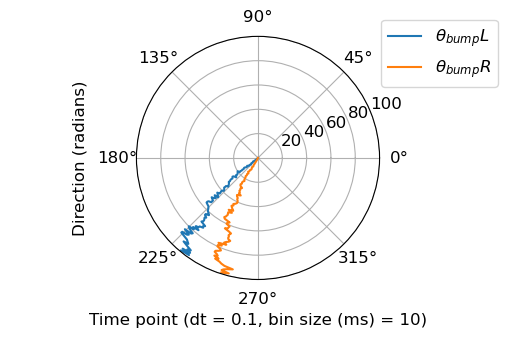

In [4]:
#| label: fig-ex2-2
#| fig-cap: "Bump location for the coupled attractor."

def exercise2_2():
    N = 300
    T = 1000
    J = 3
    I0 = 2
    R = 1
    tau = 10
    dt = 0.1
    omega = 0.01
    alpha = 2
    beta = 0.5
    r0 = 1
    theta = 10 * np.pi / 180
    np.random.seed(42)
    x_range = (0, 2*np.pi)
    time_points = np.arange(0, T, dt)
    left_pop = NeuronPopultion(N, J, x_range, time_points, I0, R, tau, dt, omega, alpha, beta, r0)
    right_pop = NeuronPopultion(N, J, x_range, time_points, I0, R, tau, dt, omega, alpha, beta, r0)
    right_I_ext = 0
    left_I_ext = 0
    
    def simulate_population(lpop: NeuronPopultion, rpop: NeuronPopultion, T):

        num_steps = int(T / dt)
        for t in range(1, num_steps):
            
            left_m_cos = np.sum(np.cos(lpop.x_positions) * lpop.spikes[:, t-1])
            left_m_sin = np.sum(np.sin(lpop.x_positions) * lpop.spikes[:, t-1])
            right_m_cos = np.sum(np.cos(rpop.x_positions) * rpop.spikes[:, t-1])
            right_m_sin = np.sum(np.sin(rpop.x_positions) * rpop.spikes[:, t-1])
            
            def calc_I(theta): # TODO: ASK ABOUT J AND N FOR STABILITY
                I_input = J / (N) * (\
                np.cos(lpop.x_positions + theta) * left_m_cos + \
                np.sin(lpop.x_positions + theta) * left_m_sin + \
                np.cos(rpop.x_positions + theta) * right_m_cos + \
                np.sin(rpop.x_positions + theta) * right_m_sin)
                return I_input 
            
            left_I_input = calc_I(theta) + left_I_ext
            lpop.sim_timestep(left_I_input, t, dt)
            right_I_input = calc_I(-theta) + right_I_ext
            rpop.sim_timestep(right_I_input, t, dt)

        return lpop, rpop


    lpop, rpop = simulate_population(left_pop, right_pop, T)
    fig, axes = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, gridspec_kw={'width_ratios': [2, 5, 2]})
    axs = axes[1]
    lpop.compute_plot_pop_vec(axs, is_polar=True, label=r'$\theta_{bump}L$')
    rpop.compute_plot_pop_vec(axs, is_polar=True, label=r'$\theta_{bump}R$')
    axs.yaxis.set_label_coords(-0.2, 0.5)  # Move ylabel to the left
    single_plot_handler(fig, axes)
    plt.show()

exercise2_2()

**Ex.2.3**: The bump-position of the two populations, and their mean, can be seen in @fig-ex2-3. Their mean has been initialised at $\pi$ This is done by initialising the two membrane potentials with noisy square-waves slightly offset from $\pi$. A slight drift can be seen over time.

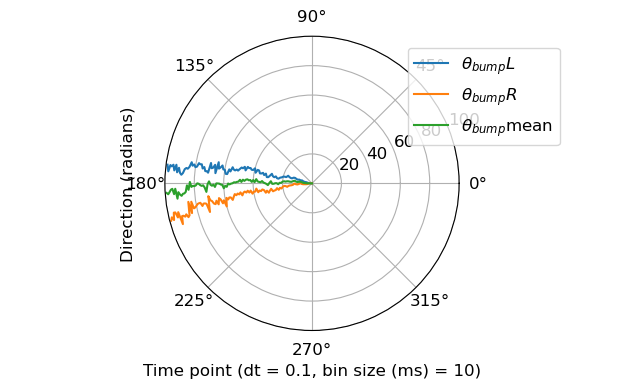

In [24]:
#| label: fig-ex2-3
#| fig-cap: "Coupled attractor with mean location at $\\pi$"
def exercise2_3():
    N = 300
    T = 1000
    J = 3
    I0 = 2
    R = 1
    tau = 10
    dt = 0.1
    omega = 0.01
    alpha = 2
    beta = 0.5
    r0 = 1
    theta = 10 * np.pi / 180
    np.random.seed(42)
    x_range = (0, 2*np.pi)
    time_points = np.arange(0, T, dt)
    rate = N/(2*np.pi)
    wl = 50
    offset = 20
    left_h_initial = np.random.uniform(0, 0.1, N)
    right_h_initial = np.random.uniform(0, 0.1, N)
    left_h_initial[int(rate*np.pi)-wl+offset:int(rate*np.pi)+wl+offset] = np.random.uniform(5, 6, 2*wl)
    right_h_initial[int(rate*np.pi)-wl-offset:int(rate*np.pi)+wl-offset] = np.random.uniform(5, 6, 2*wl)
    left_pop = NeuronPopultion(N, J, x_range, time_points, I0, R, tau, dt, omega, alpha, beta, r0, left_h_initial)
    right_pop = NeuronPopultion(N, J, x_range, time_points, I0, R, tau, dt, omega, alpha, beta, r0, right_h_initial)
    right_I_ext = 0
    left_I_ext = 0
    
    def simulate_population(lpop: NeuronPopultion, rpop: NeuronPopultion, T):

        num_steps = int(T / dt)
        for t in range(1, num_steps):
            
            left_m_cos = np.sum(np.cos(lpop.x_positions) * lpop.spikes[:, t-1])
            left_m_sin = np.sum(np.sin(lpop.x_positions) * lpop.spikes[:, t-1])
            right_m_cos = np.sum(np.cos(rpop.x_positions) * rpop.spikes[:, t-1])
            right_m_sin = np.sum(np.sin(rpop.x_positions) * rpop.spikes[:, t-1])
            
            def calc_I(theta):
                I_input = J / (N) * (\
                np.cos(lpop.x_positions + theta) * left_m_cos + \
                np.sin(lpop.x_positions + theta) * left_m_sin + \
                np.cos(rpop.x_positions + theta) * right_m_cos + \
                np.sin(rpop.x_positions + theta) * right_m_sin)
                return I_input 
            
            left_I_input = calc_I(theta) + left_I_ext
            lpop.sim_timestep(left_I_input, t, dt)
            right_I_input = calc_I(-theta) + right_I_ext
            rpop.sim_timestep(right_I_input, t, dt)

        return lpop, rpop


    lpop, rpop = simulate_population(left_pop, right_pop, T)
    fig, axes = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, gridspec_kw={'width_ratios': [1.7, 5.25, 1.7]})
    axs = axes[1]
    lpop.compute_plot_pop_vec(axs, is_polar=True, label=r'$\theta_{bump}L$')
    rpop.compute_plot_pop_vec(axs, is_polar=True, label=r'$\theta_{bump}R$')
    axs.yaxis.set_label_coords(-0.3, 0.5)  # Move ylabel to the left

    lpop_vec = lpop.compute_pop_vec(complex_form=True)
    rpop_vec = rpop.compute_pop_vec(complex_form=True)
    mean_vec = np.angle((lpop_vec + rpop_vec) / 2)
    
    plot_pop_vec(mean_vec, dt, axs, is_polar=True, label = r'$\theta_{bump} \text{mean}$')
    
    
    single_plot_handler(fig, axes)
    plt.tight_layout()
    plt.show()

exercise2_3()

**Ex.2.4**: @fig-ex2-4 shows the final location $\theta_{bump} \text{mean}$ for different values of $I_0$. An upper limit on $I_0$ that keeps the bump in a linear regime would be $I_0 \leq 0.47$ nA.

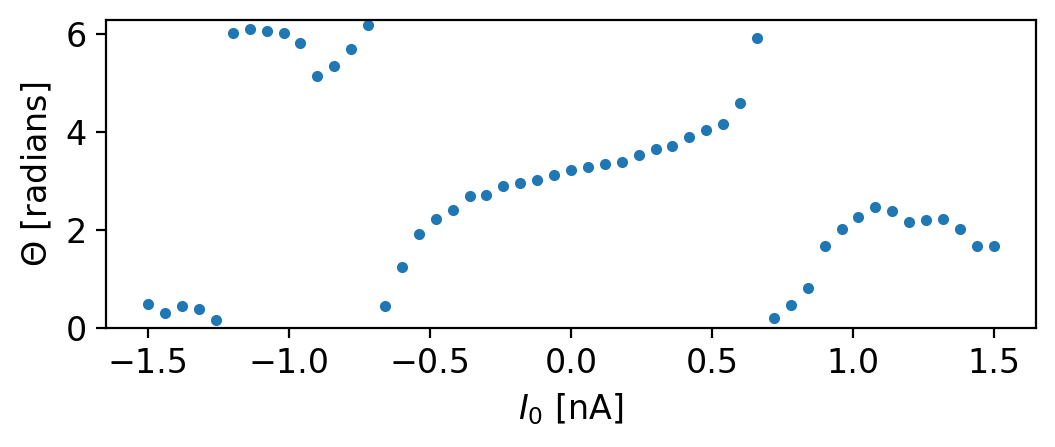

In [25]:
#| label: fig-ex2-4
#| fig-cap: "Final location of $\\theta_{bump}\\text{mean}$ for different values of $I_0$"
def exercise2_4(I_zero):
    N = 300
    T = 1000
    J = 3
    I0 = 2
    R = 1
    tau = 10
    dt = 0.1
    omega = 0.01
    alpha = 2
    beta = 0.5
    r0 = 1
    theta = 10 * np.pi / 180
    np.random.seed(42)
    x_range = (0, 2*np.pi)
    time_points = np.arange(0, T, dt)
    rate = N/(2*np.pi)
    wl = 50
    offset = 20
    left_h_initial = np.random.uniform(0, 0.1, N)
    right_h_initial = np.random.uniform(0, 0.1, N)
    left_h_initial[int(rate*np.pi)-wl+offset:int(rate*np.pi)+wl+offset] = np.random.uniform(5, 6, 2*wl)
    right_h_initial[int(rate*np.pi)-wl-offset:int(rate*np.pi)+wl-offset] = np.random.uniform(5, 6, 2*wl)
    left_pop = NeuronPopultion(N, J, x_range, time_points, I0, R, tau, dt, omega, alpha, beta, r0, left_h_initial)
    right_pop = NeuronPopultion(N, J, x_range, time_points, I0, R, tau, dt, omega, alpha, beta, r0, right_h_initial)

    I_ext = np.zeros((N, len(time_points)))
    I_ext[:, int(300/dt):int(600/dt)] = I_zero

    right_I_ext = I_ext
    left_I_ext = -I_ext
    
    def simulate_population(lpop: NeuronPopultion, rpop: NeuronPopultion, T):

        num_steps = int(T / dt)
        for t in range(1, num_steps):
            
            left_m_cos = np.sum(np.cos(lpop.x_positions) * lpop.spikes[:, t-1])
            left_m_sin = np.sum(np.sin(lpop.x_positions) * lpop.spikes[:, t-1])
            right_m_cos = np.sum(np.cos(rpop.x_positions) * rpop.spikes[:, t-1])
            right_m_sin = np.sum(np.sin(rpop.x_positions) * rpop.spikes[:, t-1])
            
            def calc_I(theta):
                I_input = J / (N) * (\
                np.cos(lpop.x_positions + theta) * left_m_cos + \
                np.sin(lpop.x_positions + theta) * left_m_sin + \
                np.cos(rpop.x_positions + theta) * right_m_cos + \
                np.sin(rpop.x_positions + theta) * right_m_sin)
                return I_input 
            
            left_I_input = calc_I(theta) + left_I_ext[:,t]
            lpop.sim_timestep(left_I_input, t, dt)
            right_I_input = calc_I(-theta) + right_I_ext[:,t]
            rpop.sim_timestep(right_I_input, t, dt)

        return lpop, rpop


    lpop, rpop = simulate_population(left_pop, right_pop, T)


    lpop_vec = lpop.compute_pop_vec(complex_form=True)
    rpop_vec = rpop.compute_pop_vec(complex_form=True)
    mean_vec = np.angle((lpop_vec + rpop_vec) / 2)
    mean_vec = np.mod(mean_vec, 2*np.pi)
    
    return np.mean(mean_vec[-10])

I0s = np.linspace(-1.5, 1.5, 51)
end_pos = []
for I0 in I0s:
    end_pos.append(exercise2_4(I0))
    
plt.figure(figsize=(6, 2),  dpi=200) 
plt.plot(I0s, end_pos, ".")
plt.ylim(0, 2*np.pi)
plt.xlabel("$I_0$ [nA]")
plt.ylabel("$\Theta$ [radians]")
plt.show()


**Ex.2.5**: This system of coupled bump attractors can be viewed as a mechanism for integration of input due to its ability to represent and maintain a stable state that integrates information over time. Each population of neurons encodes a bump that represents a specific value or variable, and the connectivity between the populations enables the integration of these representations. External inputs can perturb the bumps, causing them to shift left or right, effectively updating the integrated variable. The mutual inhibition and excitation between the populations ensure that the system maintains equilibrium and integrates the input information, making it suitable for tasks requiring continuous integration and updating of variables. 

**Ex.3.1**: The function creates a smooth random 2D trajectory with constant speed by incrementally updating the position and heading direction at each time step. The `step_size` ensures a uniform distance per step, while the `max_angle` parameter limits changes in the heading direction to avoid abrupt turns, ensuring smoothness. Starting from an initial position and heading, the function updates the position using trigonometric functions based on the current heading, which is gradually adjusted with small random perturbations. 

**Ex.3.2**:  @fig-ex3-2 shows the results of simulating the head direction cells $\theta_{bump}^H$ againts the current head direction $\theta_H$. The plot shows a strong correlation. This close match between the two, indicates that the head direction cells accurately track the actual head direction, demonstrating the effectiveness of the bump attractor network in integrating and representing head direction. Any significant mismatches could suggest that the turning speed in the trajectory generation was too fast, causing the neural network to lag.

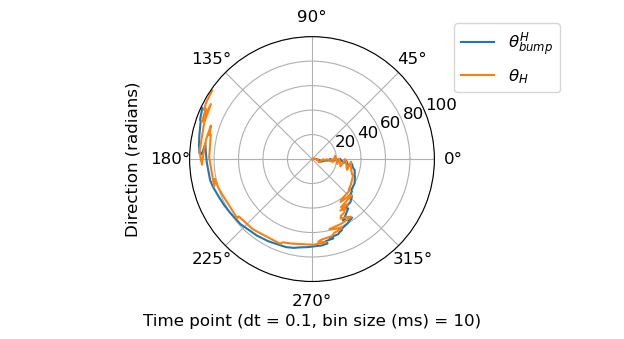

In [27]:
#| label: fig-ex3-2
#| fig-cap: "$\\theta_{bump}^H$ againts the current head direction $\\theta_H$."
def exercise3_2():
    N = 300
    T = 1000
    J = 5
    I0 = 1
    R = 1
    tau = 10
    dt = 0.1
    omega = 0.01
    alpha = 2
    beta = 0.5
    r0 = 1
    np.random.seed(42)

    x_positions = np.linspace(0, 2*np.pi, N)
    initial_h = np.random.uniform(0, 1, N)
    time_points = np.arange(0, T, dt)
    I_input = np.zeros((N, len(time_points)))

    # Generate path
    coords, headings = generate_path(0.01, len(time_points), 0.01)
    
    # Create the rquired external input based on the specification.
    I_ext = np.zeros((N, len(time_points)))
    for n_idx in range(N):
        I_ext[n_idx,:] = I0 * np.cos(x_positions[n_idx]-headings)

    def simulate_neurons(h_initial, I_input, T):
        num_neurons = len(h_initial)
        num_steps = int(T / dt)
        h_values = np.zeros((num_neurons, num_steps))
        spikes = np.zeros((num_neurons, num_steps), dtype=float)
        h_values[:, 0] = h_initial

        for t in range(1, num_steps):
            m_cos = np.sum(np.cos(x_positions) * spikes[:, t-1])/N
            m_sin = np.sum(np.sin(x_positions) * spikes[:, t-1])/N
            I_input[:, t] = J * (np.cos(x_positions) * m_cos + np.sin(x_positions) * m_sin) + I_ext[:, t]

            h_prev = h_values[:, t - 1]
            I = R * I_input[:, t]
            dh_dt = (-h_prev + I) / tau
            h_values[:, t] = h_prev + dt * dh_dt
            r = g(h_values[:, t], r0, alpha, beta)
            spike_probs = r * dt
            spikes[:, t] = (np.random.random(num_neurons) < spike_probs).astype(float)/dt

        return h_values, spikes


    h_values, spikes = simulate_neurons(initial_h, I_input, T)

    x_positions_p = np.exp(1j * x_positions)
    # Create bins of time then count the spikes for each neuron in that bin.
    time_bin_window_size_ms = 10 # ms
    time_bin_window_size = int(time_bin_window_size_ms/dt) # timesteps

    mean_heading = np.mean(headings.reshape(-1, time_bin_window_size), axis=1)
    population_vector = compute_pop_vec(spikes, N, x_positions, dt, time_bin_window_size_ms=time_bin_window_size_ms)

    fig, axes = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, gridspec_kw={'width_ratios': [2, 5, 2]})
    ax = axes[1]
    plot_pop_vec(population_vector, dt, ax, time_bin_window_size_ms=time_bin_window_size_ms, is_polar=True, label=r'$\theta_{bump}^H$')
    plot_pop_vec(mean_heading, dt, ax, time_bin_window_size_ms=time_bin_window_size_ms, is_polar=True, label=r'$\theta_H$')
    ax.yaxis.set_label_coords(-0.2, 0.5)
    single_plot_handler(fig, axes)
    plt.tight_layout()
    plt.show()

exercise3_2()

**Ex.3.3**: @fig-ex3-3 shows the values of $J_{head}$ againts the maximum current of the head population to the other two couple attractors. Values of $J_{head}$ close to $0.9$ pC give rise to an input around $0.47$ nA which as we saw in @fig-ex2-4 puts the system in a linear regime. 

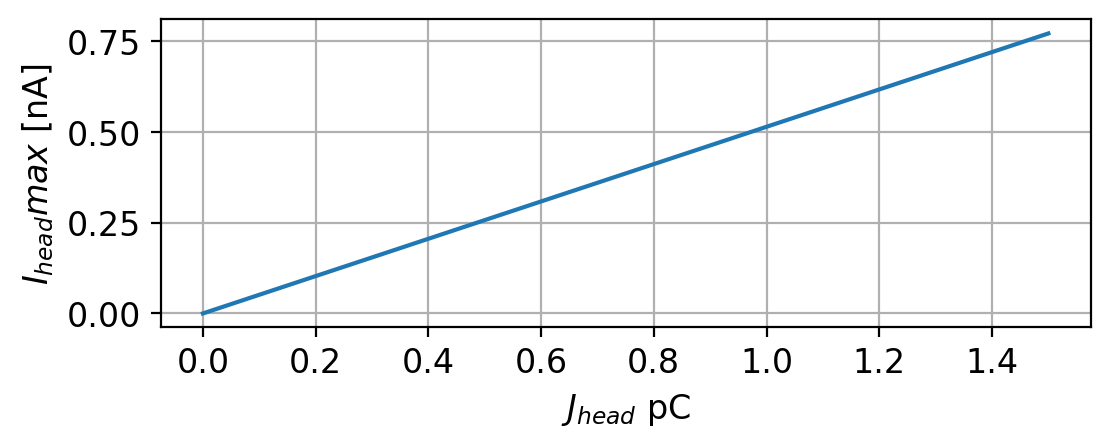

In [56]:
#| label: fig-ex3-3
#| fig-cap: "$\\theta_{bump} \\text{mean}$ againts different values of $J_{head}$"
def exercise3_3(J_head):
    N = 300
    T = 1000
    J = 3
    I0 = 1
    R = 1
    tau = 10
    dt = 0.1
    omega = 0.01
    alpha = 2
    beta = 0.5
    r0 = 1
    theta = 10 * np.pi / 180
    np.random.seed(42)
    x_range = (0, 2*np.pi)
    time_points = np.arange(0, T, dt)

    rate = N/(2*np.pi)
    wl = 50
    offset = 20
    left_h_initial = np.random.uniform(0, 0.1, N)
    right_h_initial = np.random.uniform(0, 0.1, N)
    left_h_initial[int(rate*np.pi)-wl+offset:int(rate*np.pi)+wl+offset] = np.random.uniform(5, 6, 2*wl)
    right_h_initial[int(rate*np.pi)-wl-offset:int(rate*np.pi)+wl-offset] = np.random.uniform(5, 6, 2*wl)

    left_pop = NeuronPopultion(N, J, x_range, time_points, I0, R, tau, dt, omega, alpha, beta, r0, left_h_initial)
    right_pop = NeuronPopultion(N, J, x_range, time_points, I0, R, tau, dt, omega, alpha, beta, r0, right_h_initial)
    head_pop = NeuronPopultion(N, J, x_range, time_points, I0, R, tau, dt, omega, alpha, beta, r0)

    head_pop_output = []
    coords, headings = generate_path(0.01, len(time_points), 0.01)
    I_ext = np.zeros((N, len(time_points)))
    for n_idx in range(N):
        I_ext[n_idx,:] = I0 * np.cos(head_pop.x_positions[n_idx]-headings)

    right_I_ext = np.zeros((N, len(time_points)))
    left_I_ext = np.zeros((N, len(time_points)))
    
    def simulate_population(lpop: NeuronPopultion, rpop: NeuronPopultion, hpop: NeuronPopultion, T):
        max_I_head = -np.Inf
        num_steps = int(T / dt)
        for t in range(1, num_steps):
            
            left_m_cos = np.sum(np.cos(lpop.x_positions) * lpop.spikes[:, t-1])
            left_m_sin = np.sum(np.sin(lpop.x_positions) * lpop.spikes[:, t-1])
            h_to_pop = np.sum(np.cos(hpop.x_positions) * hpop.spikes[:, t-1])
            right_m_cos = np.sum(np.cos(rpop.x_positions) * rpop.spikes[:, t-1])
            right_m_sin = np.sum(np.sin(rpop.x_positions) * rpop.spikes[:, t-1])
            
            def calc_I(theta, h_pop_sign):
                I_head = (J_head/N) * (h_pop_sign * h_to_pop)
                I_input = J / (N) * (\
                np.cos(lpop.x_positions + theta) * left_m_cos + \
                np.sin(lpop.x_positions + theta) * left_m_sin + \
                np.cos(rpop.x_positions + theta) * right_m_cos + \
                np.sin(rpop.x_positions + theta) * right_m_sin) + \
                I_head
                return I_input, I_head

            head_pop_output.append((J_head/N) * (1 * h_to_pop))
            left_I_input, l_I_head = calc_I(theta, -1)
            left_I_input += left_I_ext[:,t]
            lpop.sim_timestep(left_I_input, t, dt)
            right_I_input, r_I_head = calc_I(-theta, +1) 
            right_I_input += right_I_ext[:,t]
            rpop.sim_timestep(right_I_input, t, dt)
            hpop.sim_timestep(I_ext[:,t], t, dt)

            if max((l_I_head, r_I_head)) > max_I_head:
                max_I_head = max((l_I_head, r_I_head))

        return lpop, rpop, hpop, max_I_head


    lpop, rpop, hpop, I_head_max = simulate_population(left_pop, right_pop, head_pop, T)
    
    lpop_vec = lpop.compute_pop_vec(complex_form=True)
    rpop_vec = rpop.compute_pop_vec(complex_form=True)
    mean_vec = np.angle((lpop_vec + rpop_vec) / 2)
    mean_vec = np.mod(mean_vec, 2*np.pi)

    return I_head_max
    

J_heads = np.linspace(0, 1.5, 30)
I_head_maxs = []
for J_head in J_heads:
    I_head_max = exercise3_3(J_head)
    I_head_maxs.append(I_head_max)

plt.figure(figsize=(6, 2),  dpi=200) 
plt.plot(J_heads, I_head_maxs)
plt.grid(True)
plt.xlabel("$J_{head}$ pC")
plt.ylabel("$I_{head} max$ [nA]")
plt.show()


**Ex.3.4**: Equation @eq-ex3_4 shows the equations for the input that is received by each of the five populations.

$$
\begin{aligned}
&I_{head, i} = I_0 cos(x_i^H - \theta_H(t)) \\
&I_{left, i}^{x} = \frac{J}{N} (\sum_{j=1}^{N} cos(x_i^L+\theta - x_j^L)S_j(t)  \\
&+ \sum_{j=1}^{N} cos(x_i^L + \theta - x_j^R)S_j(t))  + \frac{J_{head}}{N}(\sum_{j=1}^{N} -cos(x_j^H)S_j(t))\\
&I_{right, i}^{x} = \frac{J}{N} (\sum_{j=1}^{N} cos(x_i^R-\theta - x_j^L)S_j(t) \\
&+ \sum_{j=1}^{N} cos(x_i^R - \theta - x_j^R)S_j(t)) + \frac{J_{head}}{N}(\sum_{j=1}^{N} cos(x_j^H)S_j(t))\\
&I_{left, i}^{y} = \frac{J}{N} (\sum_{j=1}^{N} cos(x_i^L+\theta - x_j^L)S_j(t)  \\
&+ \sum_{j=1}^{N} cos(x_i^L + \theta - x_j^R)S_j(t))  + \frac{J_{head}}{N}(\sum_{j=1}^{N} -sin(x_j^H)S_j(t))\\
&I_{right, i}^{y} = \frac{J}{N} (\sum_{j=1}^{N} cos(x_i^R-\theta - x_j^L)S_j(t) \\
&+ \sum_{j=1}^{N} cos(x_i^R - \theta - x_j^R)S_j(t)) + \frac{J_{head}}{N}(\sum_{j=1}^{N} sin(x_j^H)S_j(t))\\
\end{aligned}
$$ {#eq-ex3_4}

**Ex.3.5**: @fig-ex3-5 shows the simulation of the network with $N = 300$ number of neurons and for $T = 1000$ miliseconds for the whole trajectory. The decoded trajectory (using a linear fit on the portion of data without the initial transient activity) is shown on top of the original trajectory. The imperfections in the decoded trajectory could be attributed to drifts, noise, and inaccuricies in the integration at are inherent to the simulation.  The following parameters could be change to make the network perform bettter: 1) Decreasing the maximum angle change per step can reduce the likelihood of abrupt turns. 2) Increasing the number of neurons in the network can enhance the resolution and precision of the bump attractor. 3) Reducing noise in the system, either by modifying the spike generation mechanism or by using noise suppression techniques, can lead to a clearer signal and better decoding performance. 4) Reducing the step size can ensure that the head direction changes more smoothly and slowly, allowing the neural network to better track these changes and integrate the trajectory more accurately.



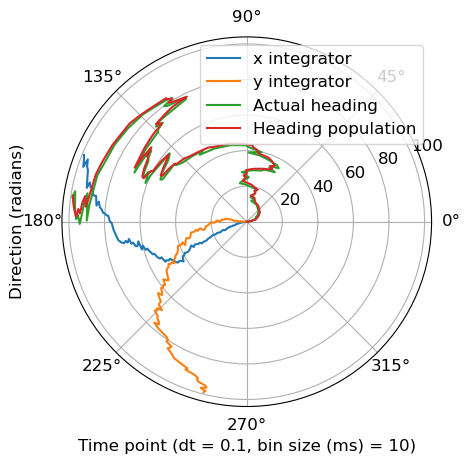

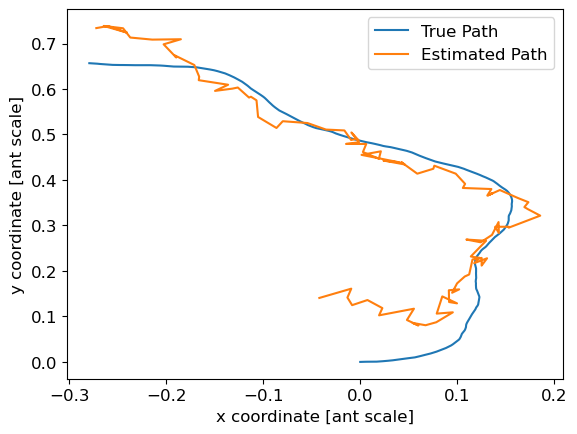

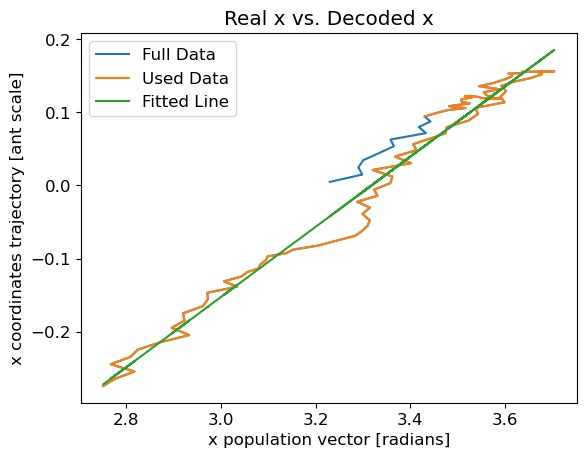

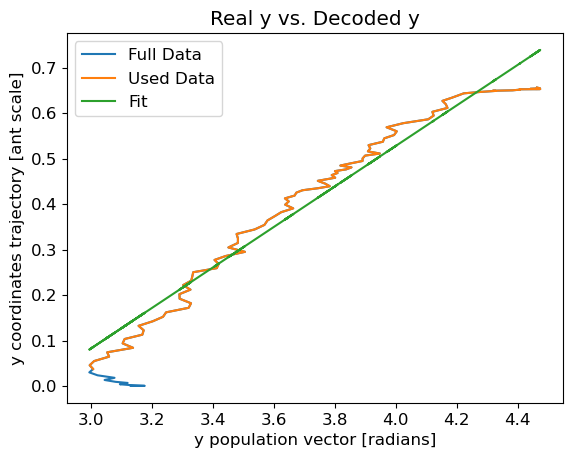

In [94]:
#| label: fig-ex3-5
#| fig-cap: "Decoded activity of the two position integrators using a linear fit shown on top of the original trajectory."
#| fig-subcap: 
#|   - "Bump location for the x integrator, y integrator, and heading cell populations along with the actual heading direction."
#|   - "The estimated trajectory from the populations shown on top of thehground truth trajectory."
#|   - "The bump location for the x integrator population fitted againts the x position of the real trajectory."
#|   - "The bump location for the y integrator population fitted againts the y position of the real trajectory."
#| layout-nrow: 2
#| layout-ncol: 2

def exercise3_5(J_head, N, T):
    J = 3
    I0 = 1
    R = 1
    tau = 10
    dt = 0.1
    omega = 0.01
    alpha = 2
    beta = 0.5
    r0 = 1
    theta = 10 * np.pi / 180
    np.random.seed(43)
    x_range = (0, 2*np.pi)
    time_points = np.arange(0, T, dt)

    rate = N/(2*np.pi)
    wl = 50
    offset = 20
    left_h_initial = np.random.uniform(0, 0.1, N)
    right_h_initial = np.random.uniform(0, 0.1, N)
    left_h_initial[int(rate*np.pi)-wl+offset:int(rate*np.pi)+wl+offset] = np.random.uniform(5, 6, 2*wl)
    right_h_initial[int(rate*np.pi)-wl-offset:int(rate*np.pi)+wl-offset] = np.random.uniform(5, 6, 2*wl)
    
    left_pop1 = NeuronPopultion(N, J, x_range, time_points, I0, R, tau, dt, omega, alpha, beta, r0, left_h_initial)
    right_pop1 = NeuronPopultion(N, J, x_range, time_points, I0, R, tau, dt, omega, alpha, beta, r0, right_h_initial)

    right_pop2 = NeuronPopultion(N, J, x_range, time_points, I0, R, tau, dt, omega, alpha, beta, r0, left_h_initial)
    left_pop2 = NeuronPopultion(N, J, x_range, time_points, I0, R, tau, dt, omega, alpha, beta, r0, right_h_initial)

    head_pop = NeuronPopultion(N, J, x_range, time_points, I0, R, tau, dt, omega, alpha, beta, r0)

    head_pop_output = []
    coords, headings = generate_path(0.0001, len(time_points),  0.008)
    I_ext = np.zeros((N, len(time_points)))
    for n_idx in range(N):
        I_ext[n_idx,:] = I0 * np.cos(head_pop.x_positions[n_idx]-headings)

    right_I_ext = np.zeros((N, len(time_points)))
    left_I_ext = np.zeros((N, len(time_points)))
    
    def simulate_population(lpop1: NeuronPopultion, rpop1: NeuronPopultion, lpop2: NeuronPopultion, rpop2: NeuronPopultion, hpop: NeuronPopultion, T):

        num_steps = int(T / dt)
        for t in range(1, num_steps):
            h_to_pop1 = np.sum(np.cos(hpop.x_positions) * hpop.spikes[:, t-1])
            h_to_pop2 = np.sum(np.sin(hpop.x_positions) * hpop.spikes[:, t-1])
            
            def get_m(lpop: NeuronPopultion, rpop: NeuronPopultion):
                left_m_cos = np.sum(np.cos(lpop.x_positions) * lpop.spikes[:, t-1])
                left_m_sin = np.sum(np.sin(lpop.x_positions) * lpop.spikes[:, t-1])
                right_m_cos = np.sum(np.cos(rpop.x_positions) * rpop.spikes[:, t-1])
                right_m_sin = np.sum(np.sin(rpop.x_positions) * rpop.spikes[:, t-1])
                return left_m_cos, left_m_sin, right_m_cos, right_m_sin
            
            def calc_I(lpop: NeuronPopultion, rpop: NeuronPopultion, theta, h_pop_sign, h_to_pop, left_m_cos, left_m_sin, right_m_cos, right_m_sin):
                I_input = (J / N) * (\
                np.cos(lpop.x_positions + theta) * left_m_cos + \
                np.sin(lpop.x_positions + theta) * left_m_sin + \
                np.cos(rpop.x_positions + theta) * right_m_cos + \
                np.sin(rpop.x_positions + theta) * right_m_sin) + \
                (J_head/N) * (h_pop_sign * h_to_pop)
                return I_input

            left_m_cos, left_m_sin, right_m_cos, right_m_sin = get_m(lpop1, rpop1)
            left_I_input = calc_I(lpop1, rpop1, theta, -1, h_to_pop1, left_m_cos, left_m_sin, right_m_cos, right_m_sin) + left_I_ext[:,t]
            right_I_input = calc_I(lpop1, rpop1, -theta, +1, h_to_pop1, left_m_cos, left_m_sin, right_m_cos, right_m_sin) + right_I_ext[:,t]
            lpop1.sim_timestep(left_I_input, t, dt)
            rpop1.sim_timestep(right_I_input, t, dt)


            left_m_cos, left_m_sin, right_m_cos, right_m_sin = get_m(lpop2, rpop2)
            left_I_input = calc_I(lpop2, rpop2, theta, -1, h_to_pop2, left_m_cos, left_m_sin, right_m_cos, right_m_sin) + left_I_ext[:,t]
            right_I_input = calc_I(lpop2, rpop2, -theta, +1, h_to_pop2, left_m_cos, left_m_sin, right_m_cos, right_m_sin) + right_I_ext[:,t]
            lpop2.sim_timestep(left_I_input, t, dt)
            rpop2.sim_timestep(right_I_input, t, dt)

            head_pop_output.append((J_head/N) * (1 * h_to_pop1))
            hpop.sim_timestep(I_ext[:,t], t, dt)

        return lpop1, rpop1, lpop2, rpop2, hpop


    lpop1, rpop1, lpop2, rpop2, hpop = simulate_population(left_pop1, right_pop1, left_pop2, right_pop2, head_pop, T)

    time_bin_window_size_ms = 10 # ms

    # Get the population vectors
    lpop1_vec = lpop1.compute_pop_vec(complex_form=True, time_bin_window_size_ms=time_bin_window_size_ms)
    rpop1_vec = rpop1.compute_pop_vec(complex_form=True, time_bin_window_size_ms=time_bin_window_size_ms)
    # Get the mean
    pop1_vec = np.mod(np.angle((lpop1_vec + rpop1_vec) / 2), 2*np.pi)
    # Convert to degrees
    lpop1_vec = np.mod(np.angle(lpop1_vec), 2*np.pi)
    rpop1_vec = np.mod(np.angle(rpop1_vec), 2*np.pi)

    # Get the population vectors
    lpop2_vec = lpop2.compute_pop_vec(complex_form=True, time_bin_window_size_ms=time_bin_window_size_ms)
    rpop2_vec = rpop2.compute_pop_vec(complex_form=True, time_bin_window_size_ms=time_bin_window_size_ms)
    # Get the mean
    pop2_vec = np.mod(np.angle((lpop2_vec + rpop2_vec) / 2), 2*np.pi)
    # Convert to degrees
    lpop2_vec = np.mod(np.angle(lpop2_vec), 2*np.pi)
    rpop2_vec = np.mod(np.angle(rpop2_vec), 2*np.pi)

    hpop_vec = hpop.compute_pop_vec(complex_form=False)


    time_bin_window_size = int(time_bin_window_size_ms/dt)
    mean_heading = np.mean(headings.reshape(-1, time_bin_window_size), axis=1)
    exclusion = round(len(pop1_vec)/10)
    binned_x = np.mean(coords[:,0].reshape(-1, time_bin_window_size), axis=1)
    binned_y = np.mean(coords[:,1].reshape(-1, time_bin_window_size), axis=1)
    x_slope, x_inter = np.polyfit(pop1_vec[exclusion:], binned_x[exclusion:], 1)
    y_slope, y_inter = np.polyfit(pop2_vec[exclusion:], binned_y[exclusion:], 1)
    
    
    fig, axs = plt.subplots(subplot_kw={'projection': 'polar'})
    axs.plot(pop1_vec, range(len(pop1_vec)), label='x integrator')
    axs.plot(pop2_vec, range(len(pop2_vec)), label='y integrator')
    axs.set_rmax(len(pop2_vec))
    axs.plot(mean_heading, range(len(mean_heading)), label='Actual heading')
    axs.plot(hpop_vec, range(len(hpop_vec)), label='Heading population')
    axs.set_xlabel('Time point (dt = {}, bin size (ms) = {})'.format(dt, time_bin_window_size_ms))
    axs.set_ylabel('Direction (radians)')
    axs.yaxis.set_label_coords(-0.1, 0.5)
    plt.legend()
    plt.show()

    
    plt.plot(coords[:,0], coords[:,1], label="True Path")
    x_est = x_inter + x_slope * pop1_vec
    y_est = y_inter + y_slope * pop2_vec
    plt.plot(x_est, y_est, label="Estimated Path")
    plt.xlabel("x coordinate [ant scale]")
    plt.ylabel("y coordinate [ant scale]")
    plt.legend()
    plt.show()
    
    plt.plot(pop1_vec, binned_x, label="Full Data")
    plt.plot(pop1_vec[exclusion:], binned_x[exclusion:], label="Used Data")
    plt.plot(pop1_vec, x_est, label="Fitted Line")
    plt.xlabel("x population vector [radians]")
    plt.ylabel("x coordinates trajectory [ant scale]")
    plt.title('Real x vs. Decoded x')
    plt.legend()
    plt.show()
    
    plt.plot(pop2_vec, binned_y, label="Full Data")
    plt.plot(pop2_vec[exclusion:], binned_y[exclusion:], label="Used Data")
    plt.plot(pop2_vec, y_est, label="Fit")
    plt.xlabel("y population vector [radians]")
    plt.ylabel("y coordinates trajectory [ant scale]")
    plt.title('Real y vs. Decoded y')
    plt.legend()
    plt.show()


J_head = 0.9
exercise3_5(J_head+0.9, 300, 1000)

**Ex.3.6**: While the simplified network that we are using aids in computational modeling, real insect neural circuits might involve more complex interactions and dynamics. Moreover, we are using a model with fixed parameters but insects may have adaptive mechanisms to fine-tune these parameters based on sensory feedback and environmental conditions. The model spatially limited as well, as it wraps around when integrating more than $\pi$, while the "physical ant" does not.

**Ex.3.7**: @fig-ex3-7 shows the performance of the network with $N = 2000$ number of neurons and for $T = 4000$ miliseconds. The estimated trajectory is now more accurate and smoother. 

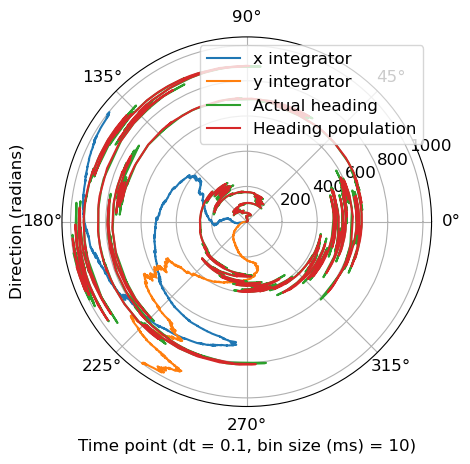

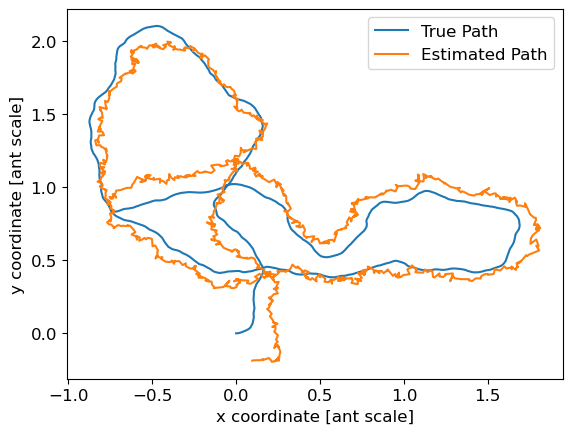

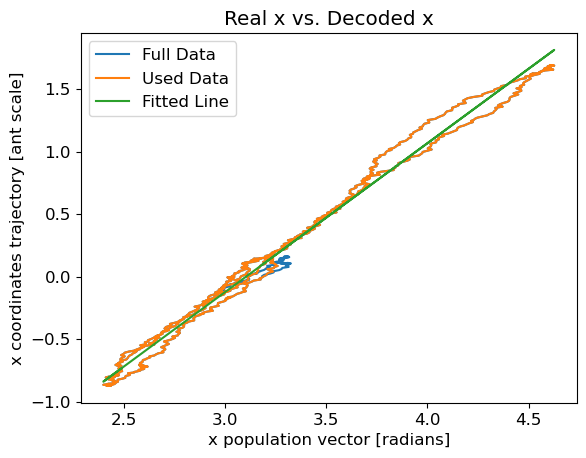

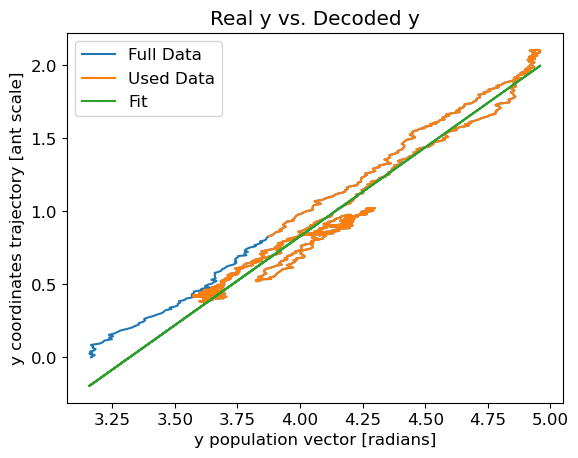

In [87]:
#| label: fig-ex3-7
#| fig-cap: "Decoded activity of the two position integrators using a linear fit shown on top of the original trajectory."
#| fig-subcap: 
#|   - "Bump location for the x integrator, y integrator, and heading cell populations along with the actual heading direction."
#|   - "The estimated trajectory from the populations shown on top of thehground truth trajectory."
#|   - "The bump location for the x integrator population fitted againts the x position of the real trajectory."
#|   - "The bump location for the y integrator population fitted againts the y position of the real trajectory."
#| layout-nrow: 2
#| layout-ncol: 2

exercise3_5(J_head, 1500, 10000)